In [1]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

from tkinter import filedialog
from scipy import stats
from sklearn import preprocessing, model_selection, pipeline, compose, metrics, neighbors

In [2]:
path_roiFts = filedialog.askdirectory(title='Diretório dos arquivos de ROIs')
path_microFts = filedialog.askdirectory(title='Diretório dos arquivos de MICROS')

Juntar as tabelas de cada em imagem em uma única tabela:

In [10]:
df_roiFts = []
for file_name in os.listdir(path_roiFts):
    file_path = os.path.join(path_roiFts, file_name)
    file_open = open(file_path, "r")
    df_file = pd.read_csv(file_open)

    df_file['im_name'] = int(file_name[0:8])

    df_roiFts.append(df_file)

df_roiFts = pd.concat(df_roiFts)
df_roiFts['n_obj'] = df_roiFts['n_obj'].fillna(value=0)


In [6]:
df_microFts = []
for file_name in os.listdir(path_microFts):
    file_path = os.path.join(path_microFts, file_name)
    file_open = open(file_path, "r")
    df_file = pd.read_csv(file_open)

    df_file['im_name'] = int(file_name[0:8])

    df_microFts.append(df_file)

df_microFts = pd.concat(df_microFts)

Organização dos dataframes:

In [11]:
##### Coluna com o Target (GROUND TRUTH)
df_roiFts['roi_target'] = df_roiFts['roi_result']
df_roiFts['roi_target'] = df_roiFts['roi_target'].replace({'false_positive':0, 'true_positive':1, 'true_negative':0, 'false_negative':1})

##### Coluna com o index dos ROIs -> nome da imagem e número do ROI
df_roiFts['key'] = df_roiFts.apply(lambda row: f'{row["im_name"]}_{row["roi_index"]}', axis=1)
df_roiFts = df_roiFts.set_index('key', drop=True)

df_roiFts = df_roiFts.drop(['Unnamed: 0', 'roi_index'], axis=1)

df_roiFts.head(n=5)

,roi_result,n_obj,i_max,i_mean,i_min,i_std,i_mean_min,i_mean_max,i_max_min,i_skew,...,t_IMC1_180,t_IMC1_270,t_IMC2_0,t_IMC2_90,t_IMC2_180,t_IMC2_270,roi_X,roi_Y,im_name,roi_target
key,,,,,,,,,,,,,,,,,,,,,
20586908_0,false_positive,2.0,0.375824,0.284488,0.000244,0.09422,0.284244,0.091336,0.37558,-2.188159,...,-0.552518,-0.506809,0.99995,0.999937,0.99997,0.999934,3984,3228,20586908,0
20586908_1,true_negative,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3984,3128,20586908,0
20586908_2,true_negative,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3984,3028,20586908,0
20586908_3,true_negative,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3984,2928,20586908,0
20586908_4,true_negative,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3984,2828,20586908,0


In [12]:
##### Coluna com o index dos ROIs -> nome da imagem e número do ROI
df_microFts['key'] = df_microFts.apply(lambda row: f'{int(row["im_name"])}_{int(row["roi_index"])}', axis=1)

df_microFts = df_microFts.drop(labels=['Unnamed: 0', 'roi_index', 'bbox_row0', 'bbox_col0', 'bbox_row1', 'bbox_col1'], axis=1)

df_microFts.head(n=5)

,area,a_bbox,major_length,minor_length,eccentricity,equivalent_diameter_area,euler_number,extent,feret_diameter_max,i_max,...,m_20,m_21,m_22,m_23,m_30,m_31,m_32,m_33,im_name,key
0,5.0,6.0,3.098387,1.788854,0.816497,2.523133,1,0.833333,3.162278,0.375824,...,2.800000,0.440000,0.584000,-0.011200,0.720000,0.792000,0.014400,0.187200,20586908,20586908_0
1,16.0,20.0,5.244535,3.920440,0.664230,4.513517,1,0.800000,5.385165,0.372894,...,16.437500,1.523438,20.550049,-3.262024,-5.648438,-5.968018,10.075500,-15.246158,20586908,20586908_0
2,12.0,12.0,6.831301,2.000000,0.956183,3.908820,1,1.000000,6.082763,0.402686,...,35.000000,0.000000,8.750000,0.000000,0.000000,0.000000,0.000000,0.000000,20586908,20586908_33
3,27.0,40.0,8.993306,4.140006,0.887741,5.863230,1,0.675000,8.944272,0.533822,...,129.407407,21.234568,185.818930,-107.421125,-95.602195,-264.348422,98.666667,-786.860743,20586908,20586908_66
4,40.0,72.0,20.155285,2.848597,0.989962,7.136496,1,0.555556,18.027756,0.539683,...,1015.100000,105.185000,382.572313,-65.627481,875.070000,400.278375,-80.804588,794.118125,20586908,20586908_66


## Resultado do processamento de segmentação

Resultados por imagem -> Número de ROIs detectados corretamente por imagem conforme ground-truth

In [13]:
table_1 = df_roiFts.groupby(by='im_name')['roi_result'].value_counts()
table_1 = table_1.unstack().fillna(value=0)
table_1['Sensibilidade'] = table_1['true_positive']/(table_1['true_positive']+table_1['false_negative'])
table_1['Precisao'] = table_1['true_positive']/(table_1['true_positive']+table_1['false_positive'])
table_1['Acuracia'] = table_1['true_positive']/(table_1['true_positive']+table_1['false_negative']+table_1['false_positive'])
table_1['N_ROIS'] = table_1['true_positive']+table_1['false_positive'] ##### numero de ROIs por imagem

img_obj_count = df_microFts.groupby('im_name')['key'].count() ##### numero de objetos por imagem
roi_obj_count = df_microFts.groupby(['key', 'im_name'])['area'].count().rename('n_objs_roi') ##### numero de objetos por ROI

###### Media do numero de objetos por ROI por imagem
for item in roi_obj_count.index.get_level_values(1).unique():
    table_1.loc[item, 'OBJS_ROI'] = roi_obj_count.iloc[roi_obj_count.index.get_level_values(1) == item].mean()

table_1 = pd.concat([table_1, img_obj_count], axis=1)

table_1.style \
  .format(precision=0, thousands='.', decimal=',', na_rep=0) \
  .format(formatter='{:.1%}', thousands='.', decimal=',', subset=['Sensibilidade', 'Precisao', 'Acuracia']) \
  .format(precision=2, thousands='.', decimal=',', subset=['OBJS_ROI']) \
  .relabel_index(['FN', 'FP', 'TN', 'TP', 'Sensib.', 'Precisão', 'Acurácia', 'N° ROIs', 'Média OBJ/ROI/IMG', 'N° OBJS'], axis=1) \
  .highlight_between(subset=['Sensibilidade', 'Precisao', 'Acuracia'], color='green', left=0.75, right=1) \
  .highlight_between(subset='Sensibilidade', color='red', left=0, right=0.40) \
  .highlight_between(subset=['Precisao', 'Acuracia'], color='red', left=0, right=0.1) \
  .highlight_between(subset=['Precisao', 'Acuracia'], color='green', left=0.20, right=1)  


,FN,FP,TN,TP,Sensib.,Precisão,Acurácia,N° ROIs,Média OBJ/ROI/IMG,N° OBJS
im_name,,,,,,,,,,
20586908,4,291,992,33,"89,2%","10,2%","10,1%",324,"2,25",730
20586934,20,206,130,103,"83,7%","33,3%","31,3%",309,"2,57",794
20586960,0,303,979,38,"100,0%","11,1%","11,1%",341,"2,19",747
20586986,12,287,176,41,"77,4%","12,5%","12,1%",328,"2,27",746
20587174,0,136,8,18,"100,0%","11,7%","11,7%",154,"5,04",776
20587226,1,176,34,29,"96,7%","14,1%","14,1%",205,"3,64",746
20587466,6,70,42,37,"86,0%","34,6%","32,7%",107,"6,06",648
20587492,0,91,695,39,"100,0%","30,0%","30,0%",130,"4,96",645
20587518,4,93,61,50,"92,6%","35,0%","34,0%",143,"4,21",602


Média e Desvio Padrão dos resultados de todas as imagens:

In [14]:
table_2 = pd.DataFrame([table_1.mean(), table_1.std()], index=['mean', 'std']).T

table_2.style \
    .format(precision=2, thousands='.', decimal=',') \
    .format(formatter='{:.2%}', thousands='.', decimal=',', subset=pd.IndexSlice[['Sensibilidade', 'Precisao', 'Acuracia'], :]) \
    .relabel_index(labels=['Mean', 'STD'], axis=1) \
    .relabel_index(labels=['Mean', 'STD'], axis=1).relabel_index(labels=['FN', 'FP', 'TN', 'TP', 'Sensibilidade', 'Precisão', 'Acurácia', 'N° ROIs', 'Média OBJ/ROI/IMG', 'N° OBJS'], axis=0)

,Mean,STD
FN,"4,35","5,74"
FP,"223,87","65,55"
TN,"435,62","383,46"
TP,"28,10","21,03"
Sensibilidade,"89,27%","11,20%"
Precisão,"11,84%","9,42%"
Acurácia,"11,55%","9,04%"
N° ROIs,"251,97","63,31"
Média OBJ/ROI/IMG,"2,95","0,84"
N° OBJS,"695,45","64,85"


Combinação de atributos:

In [15]:
##### Média e desvio padrão dos atributos de textura
df_roiFts.loc[:, 't_ASM_mean'] = df_roiFts.loc[:, ['t_ASM_0', 't_ASM_90', 't_ASM_180', 't_ASM_270']].mean(axis=1)
df_roiFts.loc[:, 't_ASM_std'] = df_roiFts.loc[:, ['t_ASM_0', 't_ASM_90', 't_ASM_180', 't_ASM_270']].std(axis=1)
df_roiFts.loc[:, 't_contrast_mean'] = df_roiFts.loc[:, ['t_contrast_0', 't_contrast_90', 't_contrast_180', 't_contrast_270']].mean(axis=1)
df_roiFts.loc[:, 't_contrast_std'] = df_roiFts.loc[:, ['t_contrast_0', 't_contrast_90', 't_contrast_180', 't_contrast_270']].std(axis=1)
df_roiFts.loc[:, 't_correlation_mean'] = df_roiFts.loc[:, ['t_correlation_0', 't_correlation_90', 't_correlation_180', 't_correlation_270']].mean(axis=1)
df_roiFts.loc[:, 't_correlation_std'] = df_roiFts.loc[:, ['t_correlation_0', 't_correlation_90', 't_correlation_180', 't_correlation_270']].std(axis=1)
df_roiFts.loc[:, 't_sumSqrVariance_mean'] = df_roiFts.loc[:, ['t_sumSqrVariance_0', 't_sumSqrVariance_90', 't_sumSqrVariance_180', 't_sumSqrVariance_270']].mean(axis=1)
df_roiFts.loc[:, 't_sumSqrVariance_std'] = df_roiFts.loc[:, ['t_sumSqrVariance_0', 't_sumSqrVariance_90', 't_sumSqrVariance_180', 't_sumSqrVariance_270']].std(axis=1)
df_roiFts.loc[:, 't_idm_mean'] = df_roiFts.loc[:, ['t_idm_0', 't_idm_90', 't_idm_180', 't_idm_270']].mean(axis=1)
df_roiFts.loc[:, 't_idm_std'] = df_roiFts.loc[:, ['t_idm_0', 't_idm_90', 't_idm_180', 't_idm_270']].std(axis=1)
df_roiFts.loc[:, 't_sumAverage_mean'] = df_roiFts.loc[:, ['t_sumAverage_0', 't_sumAverage_90', 't_sumAverage_180', 't_sumAverage_270']].mean(axis=1)
df_roiFts.loc[:, 't_sumAverage_std'] = df_roiFts.loc[:, ['t_sumAverage_0', 't_sumAverage_90', 't_sumAverage_180', 't_sumAverage_270']].std(axis=1)
df_roiFts.loc[:, 't_sumVariance_mean'] = df_roiFts.loc[:, ['t_sumVariance_0', 't_sumVariance_90', 't_sumVariance_180', 't_sumVariance_270']].mean(axis=1)
df_roiFts.loc[:, 't_sumVariance_std'] = df_roiFts.loc[:, ['t_sumVariance_0', 't_sumVariance_90', 't_sumVariance_180', 't_sumVariance_270']].std(axis=1)
df_roiFts.loc[:, 't_sumEntropy_mean'] = df_roiFts.loc[:, ['t_sumEntropy_0', 't_sumEntropy_90', 't_sumEntropy_180', 't_sumEntropy_270']].mean(axis=1)
df_roiFts.loc[:, 't_sumEntropy_std'] = df_roiFts.loc[:, ['t_sumEntropy_0', 't_sumEntropy_90', 't_sumEntropy_180', 't_sumEntropy_270']].std(axis=1)
df_roiFts.loc[:, 't_IMC2_mean'] = df_roiFts.loc[:, ['t_entropy_0', 't_entropy_90', 't_entropy_180', 't_entropy_270']].mean(axis=1)
df_roiFts.loc[:, 't_entropy_std'] = df_roiFts.loc[:, ['t_entropy_0', 't_entropy_90', 't_entropy_180', 't_entropy_270']].std(axis=1)
df_roiFts.loc[:, 't_diffVariance_mean'] = df_roiFts.loc[:, ['t_diffVariance_0', 't_diffVariance_90', 't_diffVariance_180', 't_diffVariance_270']].mean(axis=1)
df_roiFts.loc[:, 't_diffVariance_std'] = df_roiFts.loc[:, ['t_diffVariance_0', 't_diffVariance_90', 't_diffVariance_180', 't_diffVariance_270']].std(axis=1)
df_roiFts.loc[:, 't_diffEntropy_mean'] = df_roiFts.loc[:, ['t_diffEntropy_0', 't_diffEntropy_90', 't_diffEntropy_180', 't_diffEntropy_270']].mean(axis=1)
df_roiFts.loc[:, 't_diffEntropy_std'] = df_roiFts.loc[:, ['t_diffEntropy_0', 't_diffEntropy_90', 't_diffEntropy_180', 't_diffEntropy_270']].std(axis=1)
df_roiFts.loc[:, 't_IMC1_mean'] = df_roiFts.loc[:, ['t_IMC1_0', 't_IMC1_90', 't_IMC1_180', 't_IMC1_270']].mean(axis=1)
df_roiFts.loc[:, 't_IMC1_std'] = df_roiFts.loc[:, ['t_IMC1_0', 't_IMC1_90', 't_IMC1_180', 't_IMC1_270']].std(axis=1)
df_roiFts.loc[:, 't_IMC2_mean'] = df_roiFts.loc[:, ['t_IMC2_0', 't_IMC2_90', 't_IMC2_180', 't_IMC2_270']].mean(axis=1)
df_roiFts.loc[:, 't_IMC2_std'] = df_roiFts.loc[:, ['t_IMC2_0', 't_IMC2_90', 't_IMC2_180', 't_IMC2_270']].std(axis=1)

In [16]:
##### Média dos itens correspondentes em micro_train
mean_values = df_microFts.iloc[:,5:].groupby('key').mean()
mean_values.columns = ['obj_'+col for col in mean_values.columns]

df_roiFts = pd.concat([df_roiFts, mean_values], axis=1)

In [17]:
##### Combinação de atributos das tabelas de ROI e de MICRO
df_roiFts.loc[:, 'feat_1'] = np.abs(df_roiFts.loc[:, 'obj_i_max'] - df_roiFts.loc[:, 'i_max'])
df_roiFts.loc[:, 'feat_2'] = df_roiFts.loc[:, 'obj_i_max']/df_roiFts.loc[:, 'i_max']
df_roiFts.loc[:, 'feat_3'] = np.abs(df_roiFts.loc[:, 'obj_i_max'] - df_roiFts.loc[:, 'i_mean'])
df_roiFts.loc[:, 'feat_4'] = df_roiFts.loc[:, 'obj_i_max']/df_roiFts.loc[:, 'i_mean']
df_roiFts.loc[:, 'feat_5'] = np.abs(df_roiFts.loc[:, 'obj_i_mean'] - df_roiFts.loc[:, 'i_max'])
df_roiFts.loc[:, 'feat_6'] = df_roiFts.loc[:, 'obj_i_mean']/df_roiFts.loc[:, 'i_max']
df_roiFts.loc[:, 'feat_7'] = np.abs(df_roiFts.loc[:, 'obj_i_mean'] - df_roiFts.loc[:, 'i_mean'])
df_roiFts.loc[:, 'feat_8'] = df_roiFts.loc[:, 'obj_i_mean']/df_roiFts.loc[:, 'i_mean']

In [ ]:
#### TO-DO -> diferença de intensidade entre cada e objeto e o roi
#### diff_values = (micro_train.loc[:,['key', 'i_max']].set_index('key') - roi_train.loc[:,['key', 'i_max']].set_index('key'))

Divisão do total de imagens em 2 partes para compor o set de TESTE e de TREINAMENTO:

In [18]:
img_train, img_test = model_selection.train_test_split(df_roiFts['im_name'].unique(), test_size=0.35, train_size=0.65, random_state=654)

Criar o dataframes de treinamento e teste:

In [19]:
roi_train = df_roiFts.loc[df_roiFts['im_name'].isin(img_train)]
micro_train = df_microFts.loc[df_microFts['key'].isin(roi_train.index)]

roi_test = df_roiFts.loc[df_roiFts['im_name'].isin(img_test)]
micro_test = df_microFts.loc[df_microFts['key'].isin(roi_test.index)]

Atributos não numéricos:

In [20]:
non_att = ['roi_result', 'roi_target', 'im_name', 'roi_X', 'roi_Y', 'obj_im_name']

## Análise do dataframe de treinamento

#### Histogramas

In [ ]:
roi_train.loc[:, ~roi_train.columns.isin(non_att)].describe()

In [ ]:
for col in roi_train.loc[:, ~roi_train.columns.isin(non_att)]:
    fig, ax = plt.subplots()
    ax.hist(roi_train[col], bins=100, density=False, histtype='step', log=False, color='blue')
    #  ax.hist(roi_train.loc[roi_train['roi_result'] == 'False_negative', col], bins=100, density=False, histtype='step', log=False, color='purple')
    ax.hist(roi_train.loc[roi_train['roi_result'] == 'false_positive', col], bins=100, density=False, histtype='step', log=False, color='red')
    ax.hist(roi_train.loc[roi_train['roi_result'] == 'true_positive', col], bins=100, density=False, histtype='step', log=False, color='green')
    plt.grid(True)
    plt.title(col)
    plt.show()

#### Boxplots

In [ ]:
for col in roi_train.loc[:, ~roi_train.columns.isin(non_att)]:
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,10))
    # ax[0].boxplot(roi_train.loc[roi_train['roi_result'] == 'False_negative', col], notch=True)
    # ax[0].set_title('Falso negativo')
    # ax[0].grid(True)
    ax[0].boxplot(roi_train.loc[roi_train['roi_result'] == 'false_positive', col], notch=True)
    ax[0].set_title('Falso positivo')
    ax[0].grid(True)
    ax[1].boxplot(roi_train.loc[roi_train['roi_result'] == 'true_positive', col], notch=True)
    ax[1].set_title('Verdadeiro Positivo')
    ax[1].grid(True)
    plt.suptitle(col)
    plt.show()

## Balancear dataframe de treinamento -> Igualar o número de alvos True e False

In [22]:
df_train = pd.concat([
    roi_train.loc[roi_train['roi_result']=='true_positive', :],
    roi_train.loc[roi_train['roi_result']=='false_positive', :].sample(roi_train.loc[roi_train['roi_result']=='true_positive', :].shape[0], random_state=654)
])
df_train[['roi_result', 'roi_target']].value_counts()

roi_result      roi_target
false_positive  0             3353
true_positive   1             3353
Name: count, dtype: int64

## Pré-processamento do dataframe


#### Histogramas do dataframe de treinamento

In [ ]:
for col in df_train.loc[:, ~df_train.columns.isin(non_att)]:
    fig, ax = plt.subplots()
    ax.hist(df_train[col], bins=100, density=False, histtype='step', log=False, color='blue')
    plt.grid(True)
    plt.title(col)
    plt.show()

#### Boxplots do dataframe de treinamento

In [ ]:
for col in df_train.iloc[:, 3:-2]:
    fig, ax = plt.subplots()
    ax.boxplot(df_train[col], vert=False)
    plt.grid(True)
    plt.title(col)
    plt.show()

#### Pipeline para pré-processamento dos dados

In [23]:
###### Caractaristicas para Power Transformation
set_power = np.logical_and(df_train.loc[:, ~df_train.columns.isin(non_att)].skew() > 1, df_train.loc[:, ~df_train.columns.isin(non_att)].skew() <= 3)
set_power = set_power.iloc[np.where(set_power)].index

###### Características para Standard Scaler
set_base = df_train.loc[:, ~df_train.columns.isin(non_att)].columns.isin(set_power)
set_base = df_train.loc[:, ~df_train.columns.isin(non_att)].columns[np.where(~set_base)]

In [24]:
####### Criar pipelines específicas conforme necessidade dos dados
base_pipeline = pipeline.make_pipeline(
    preprocessing.StandardScaler()
)

power_pipeline = pipeline.make_pipeline(
    preprocessing.PowerTransformer(method='yeo-johnson', standardize=True),
)

###### Operador para aplicar cada pipeline na coluna específica
p_processing = compose.ColumnTransformer([
    ('power', power_pipeline, set_power),
    ('base', base_pipeline, set_base)
], remainder='passthrough')

p_processing.set_output(transform='pandas')

##### aplicar os operadores no dataframe
df_train_scaled = p_processing.fit_transform(df_train.loc[:, ~df_train.columns.isin(non_att)])
df_train_scaled = pd.concat([df_train_scaled, df_train['roi_target']], axis=1)

### Correlação entre variáveis

In [26]:
corr_matrix = df_train_scaled.iloc[:,2:].corr()
corr_matrix['roi_target'].sort_values(ascending=False) ### Correlação entre as variáveis e o resultado esperado

roi_target                    1.000000
base__obj_i_max               0.322449
base__obj_i_mean              0.309222
base__feat_5                  0.293180
base__i_mean_max              0.287422
                                ...   
power__t_diffVariance_270    -0.255629
power__t_diffVariance_180    -0.257343
power__t_diffVariance_mean   -0.269778
base__feat_2                 -0.271578
base__feat_6                 -0.292516
Name: roi_target, Length: 132, dtype: float64

Selecionando variáveis pelo valor da correlação com o resultado esperado

In [27]:
fts_pos = corr_matrix['roi_target'].sort_values(ascending=False) >= 0.2
fts_neg = corr_matrix['roi_target'].sort_values(ascending=False) <= -0.2

slc_fts = np.array(corr_matrix[np.logical_and(np.logical_or(fts_pos, fts_neg), corr_matrix['roi_target'].sort_values(ascending=False) != 1.0)].index)
slc_fts

C:\Users\br_go\AppData\Local\Temp\ipykernel_14116\3646125702.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slc_fts = np.array(corr_matrix[np.logical_and(np.logical_or(fts_pos, fts_neg), corr_matrix['roi_target'].sort_values(ascending=False) != 1.0)].index)


array(['power__i_max_min', 'power__t_diffVariance_0',
       'power__t_diffVariance_90', 'power__t_diffVariance_180',
       'power__t_diffVariance_270', 'power__t_entropy_std',
       'power__t_diffVariance_mean', 'power__t_IMC1_std',
       'power__t_IMC2_std', 'base__i_mean', 'base__i_mean_max',
       'base__i_mode_count', 'base__t_sumAverage_0',
       'base__t_sumAverage_90', 'base__t_sumAverage_180',
       'base__t_sumAverage_270', 'base__t_entropy_0',
       'base__t_entropy_90', 'base__t_entropy_180', 'base__t_entropy_270',
       'base__t_sumAverage_mean', 'base__obj_i_max', 'base__obj_i_mean',
       'base__obj_i_min', 'base__feat_1', 'base__feat_2', 'base__feat_5',
       'base__feat_6'], dtype=object)

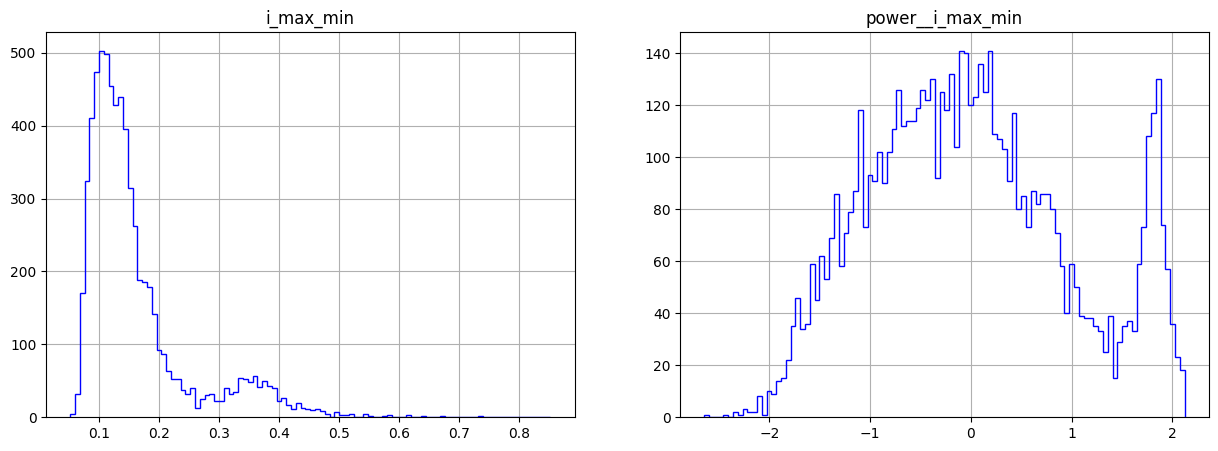

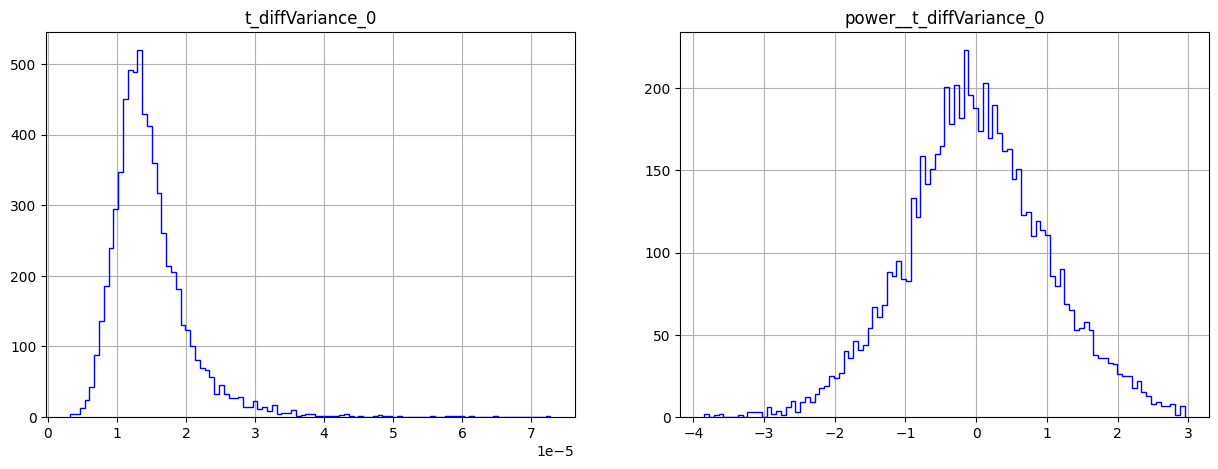

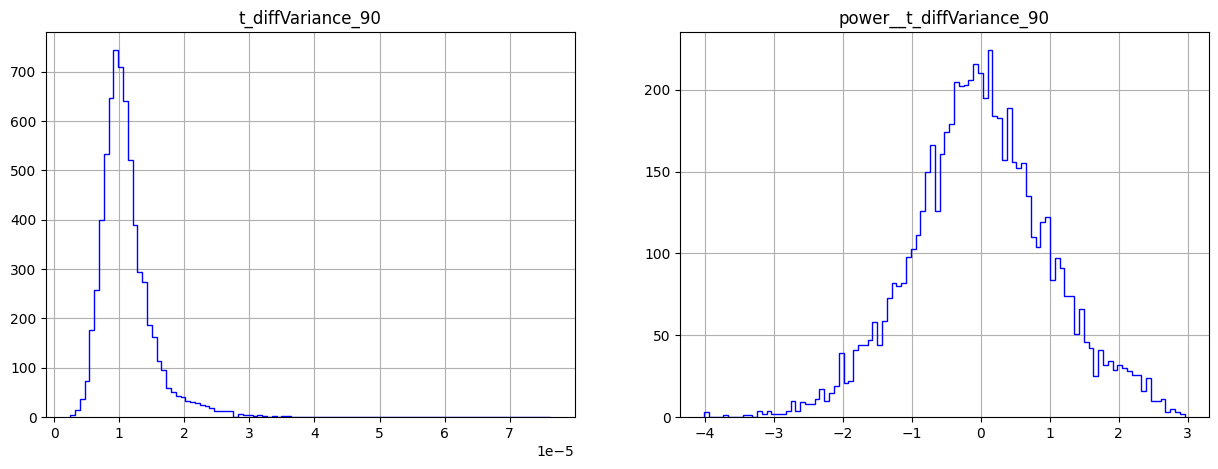

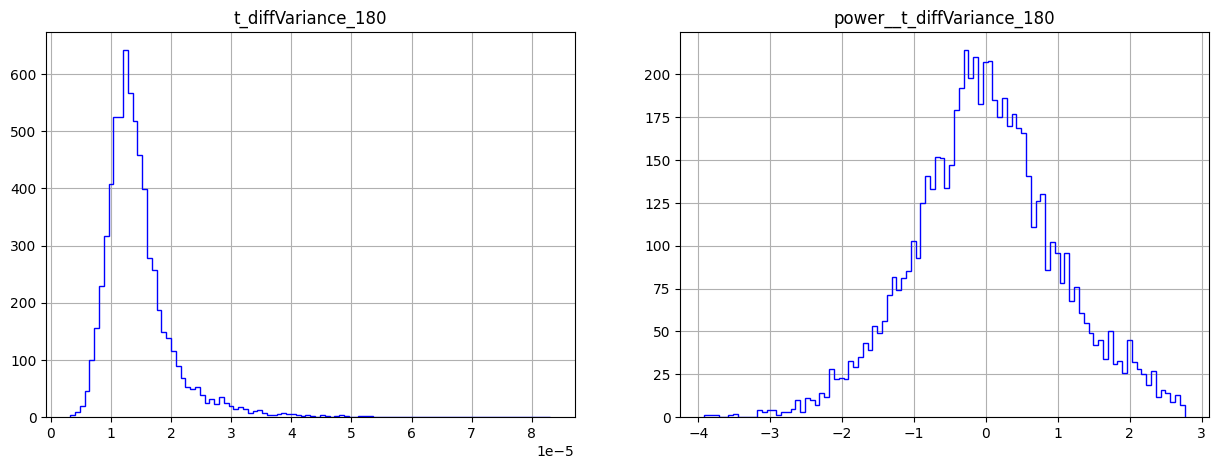

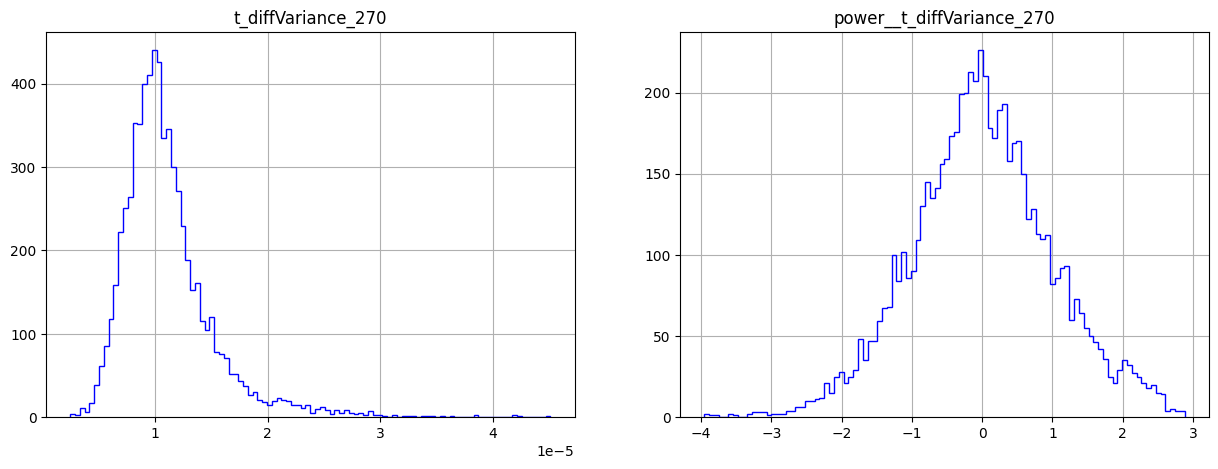

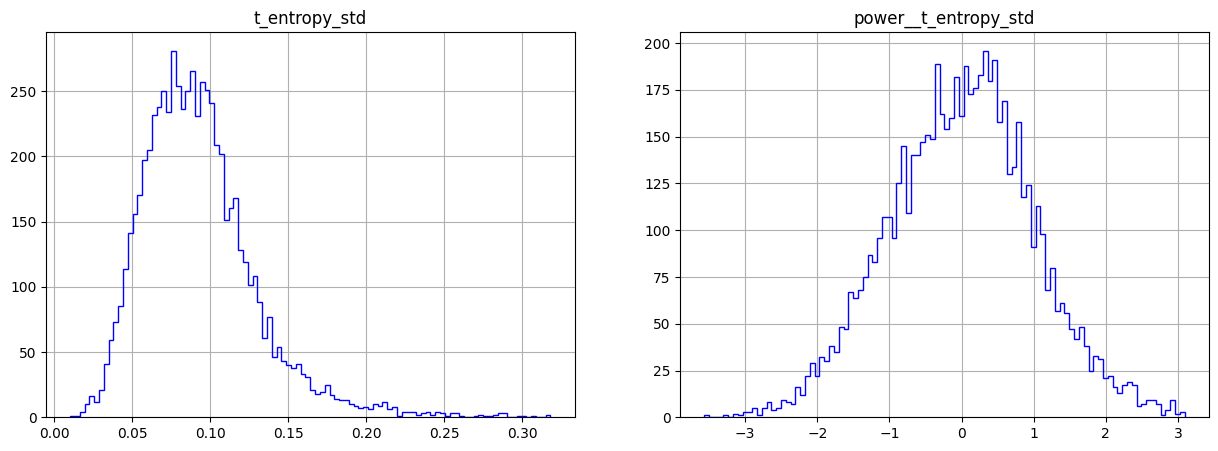

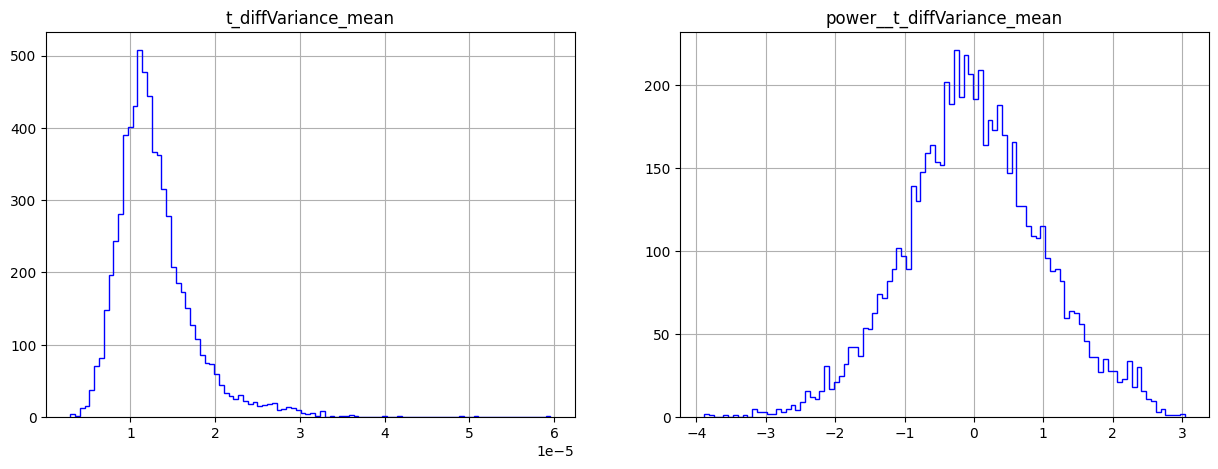

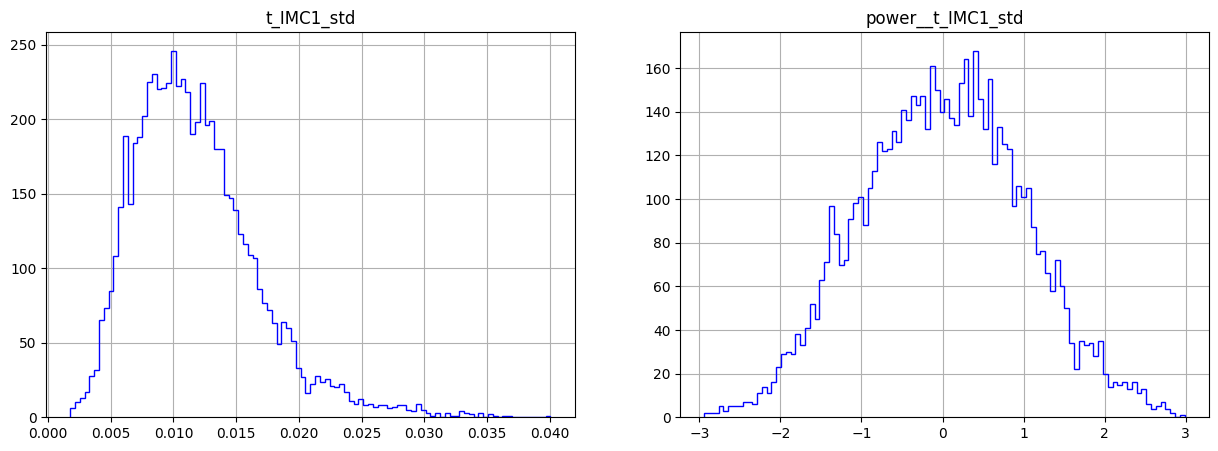

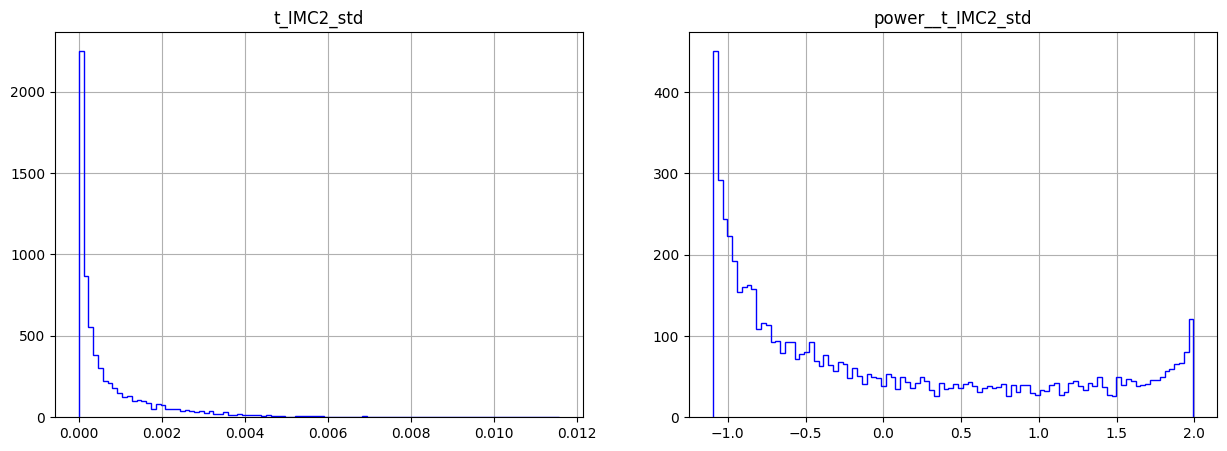

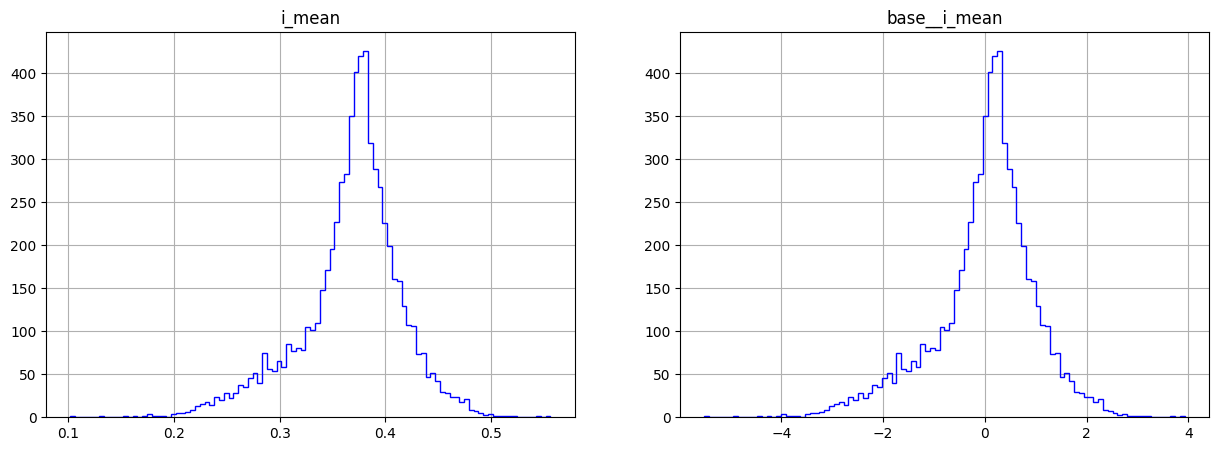

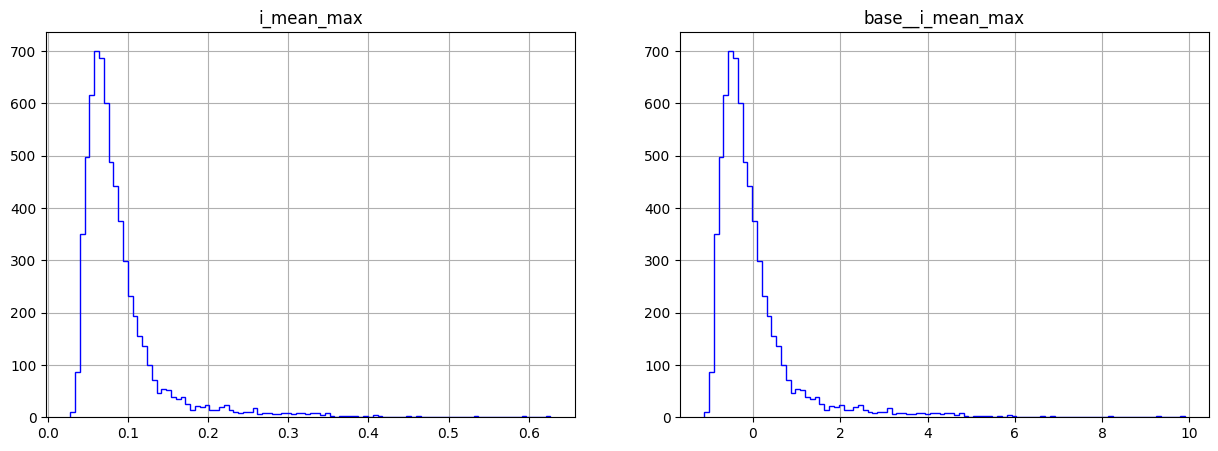

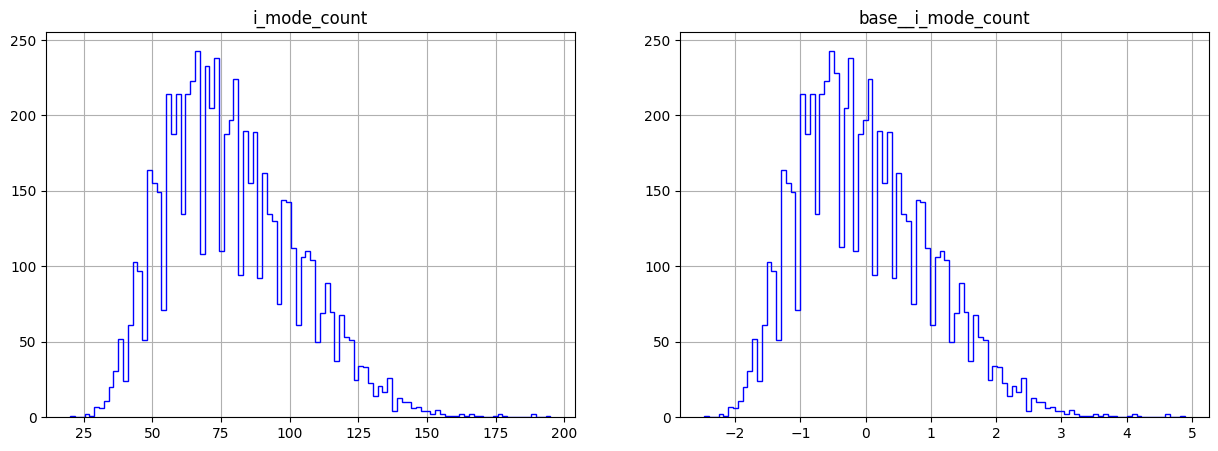

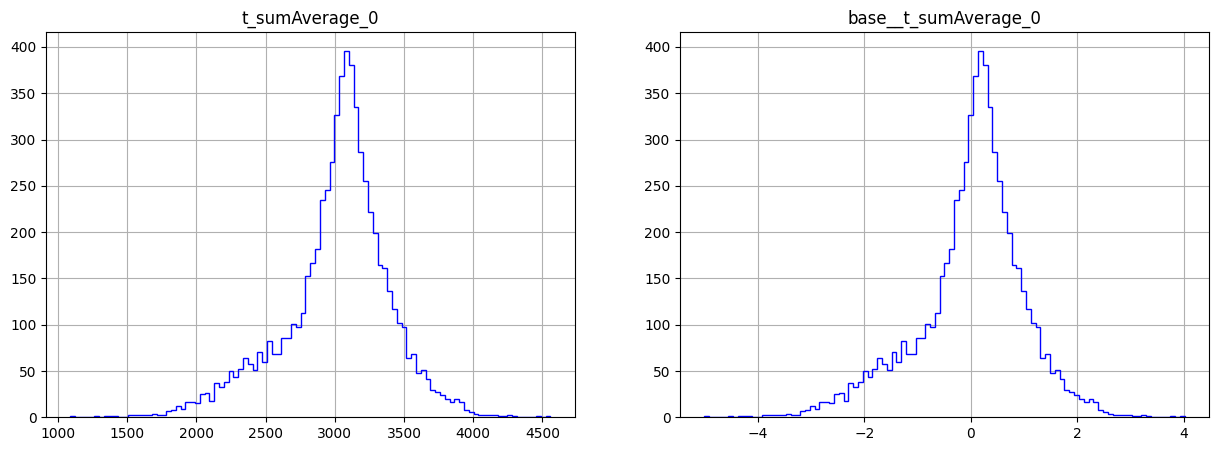

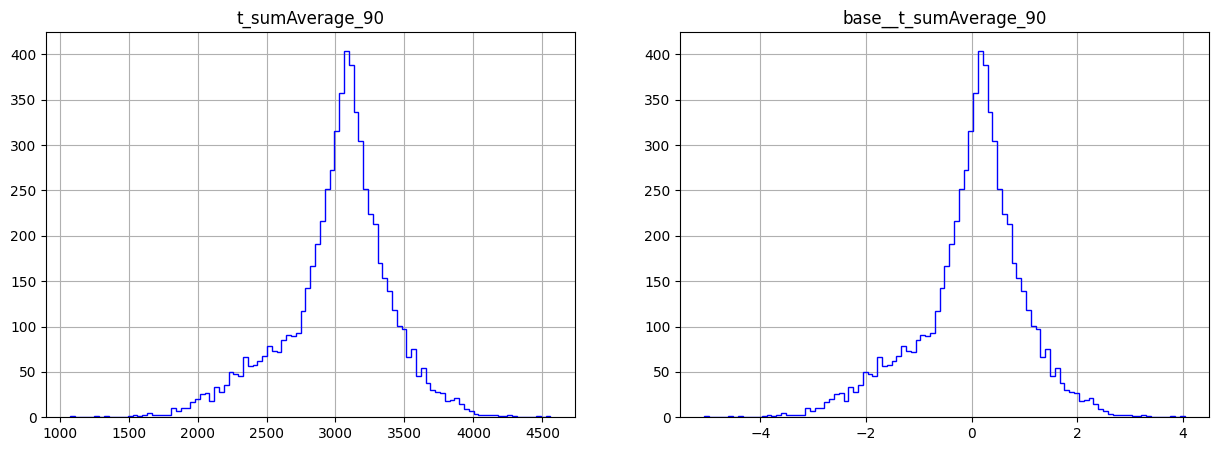

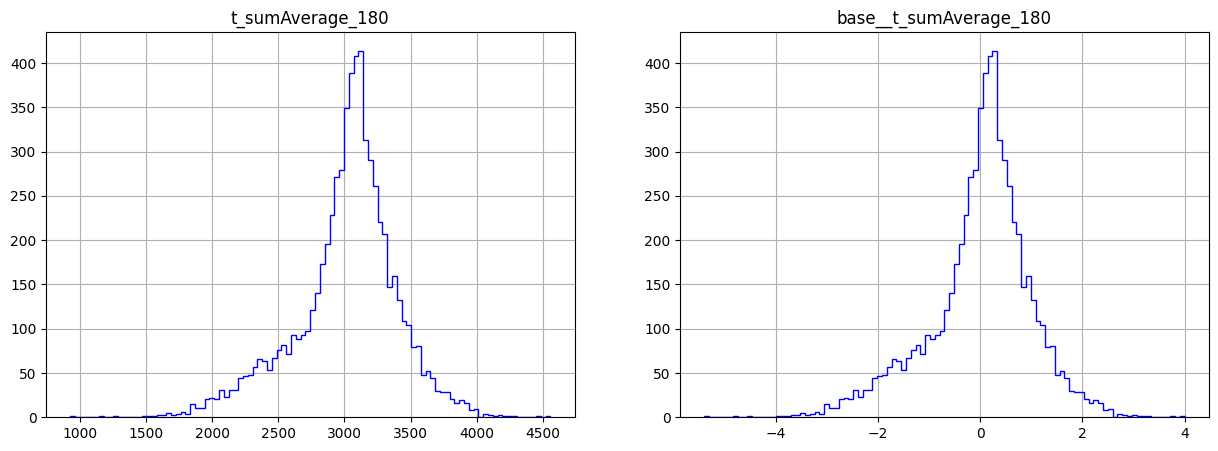

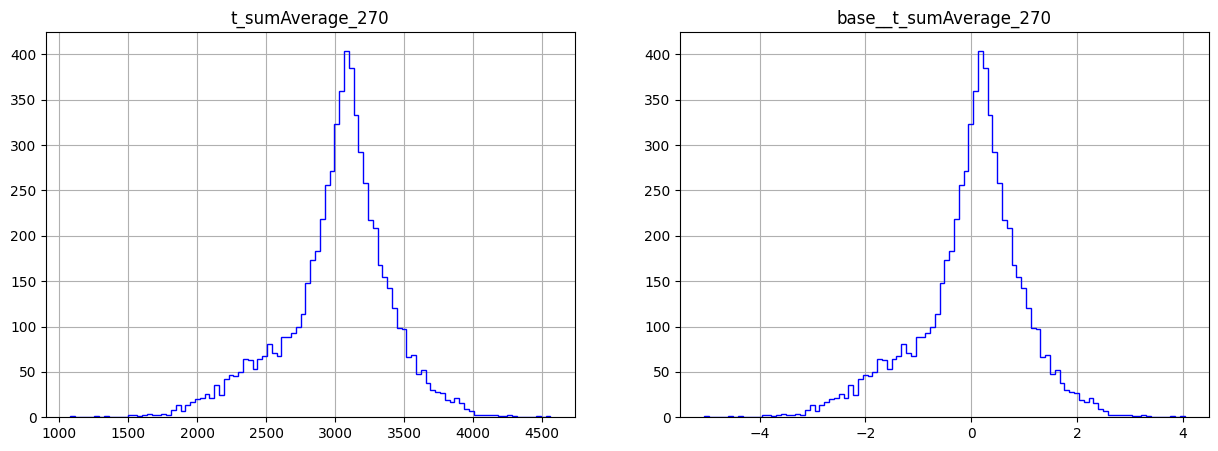

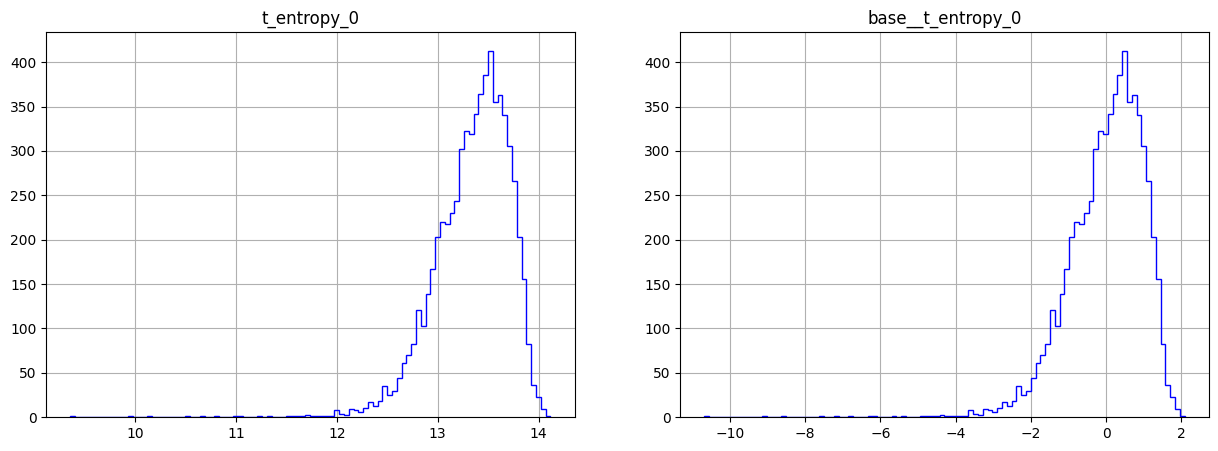

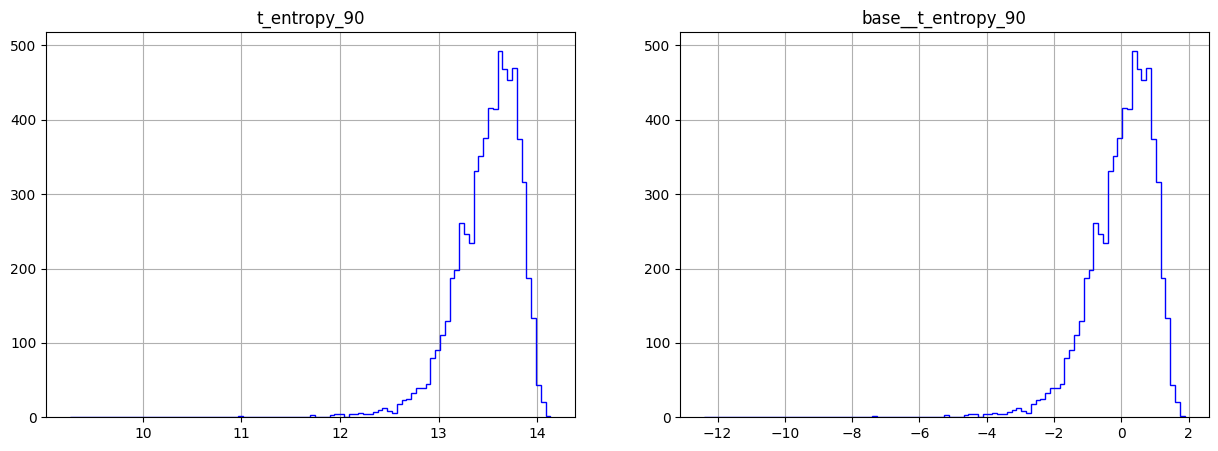

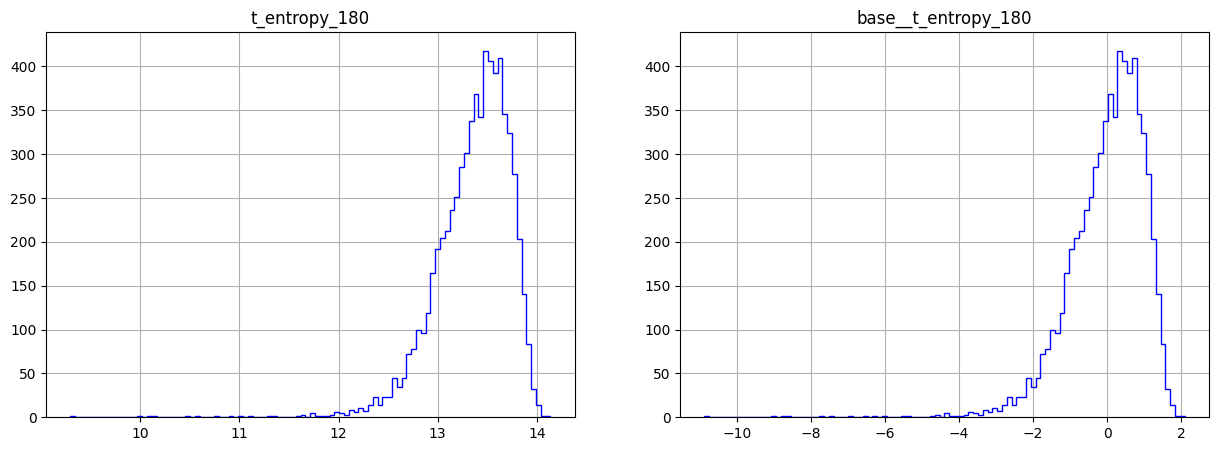

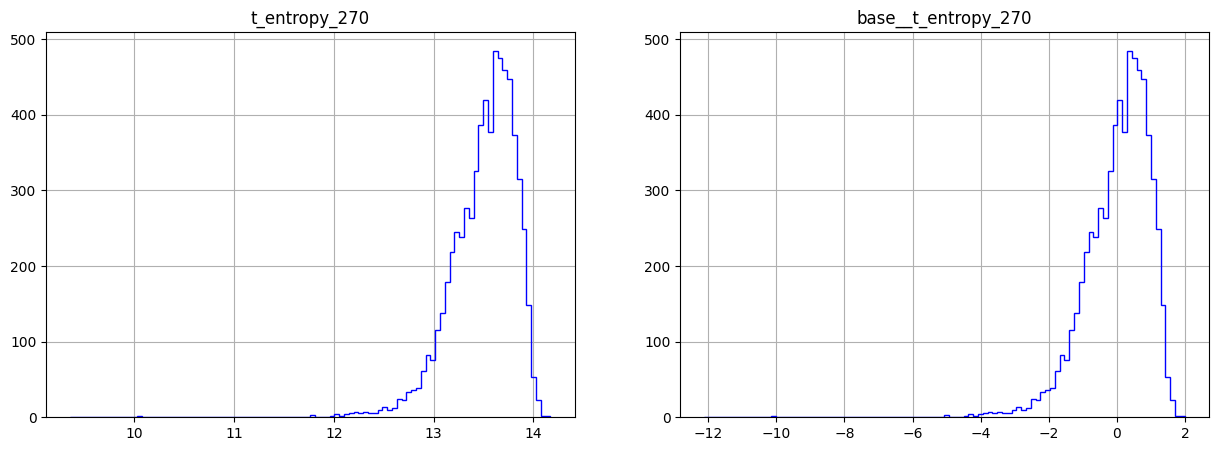

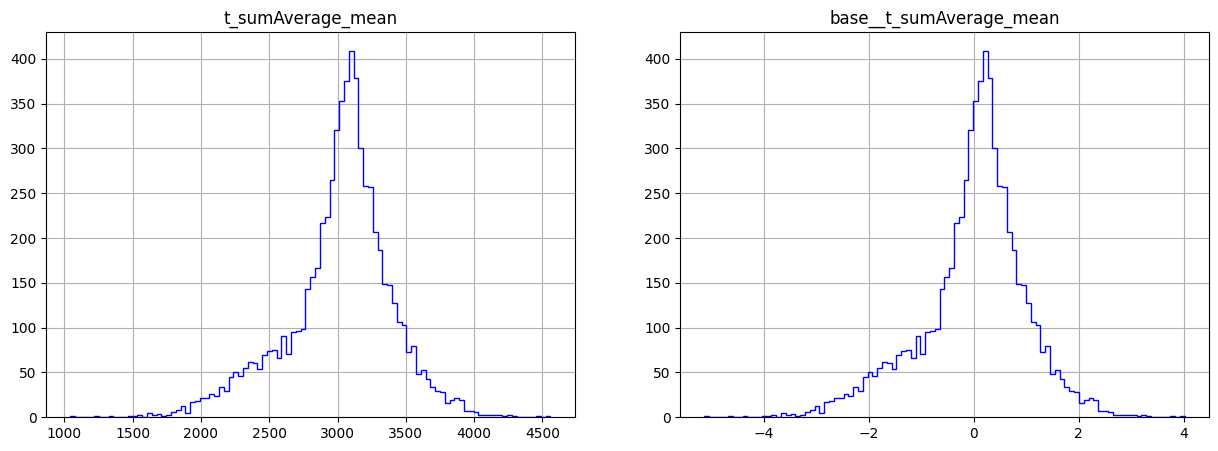

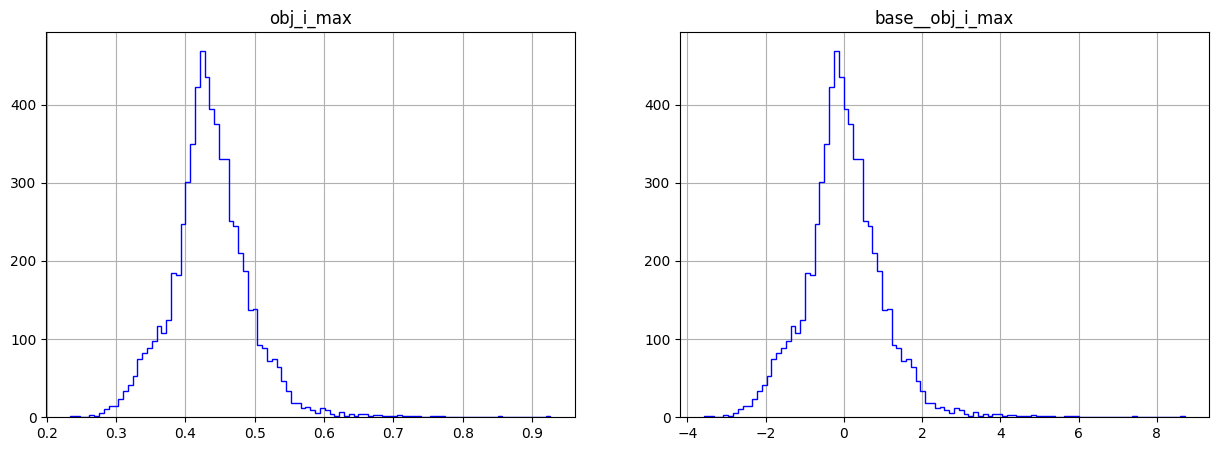

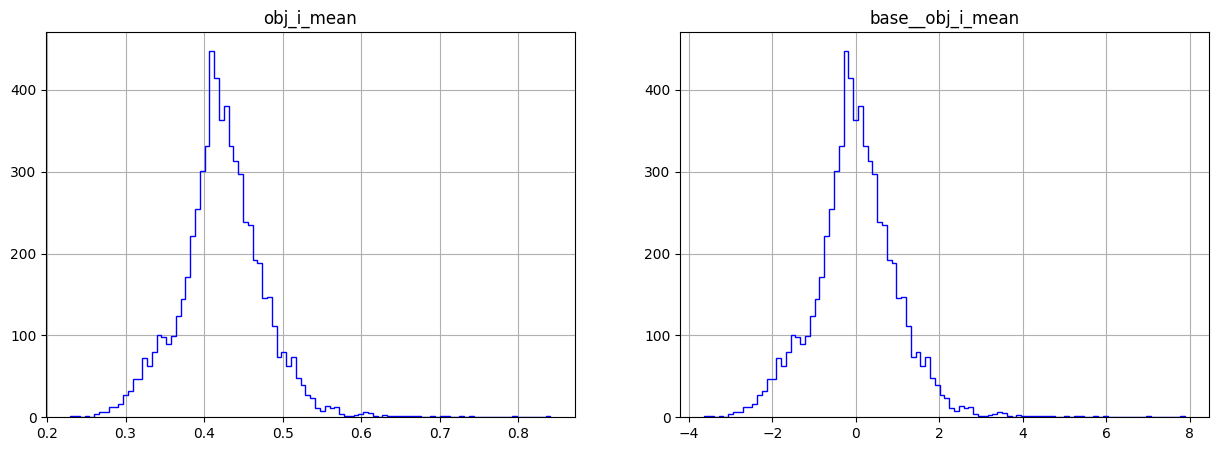

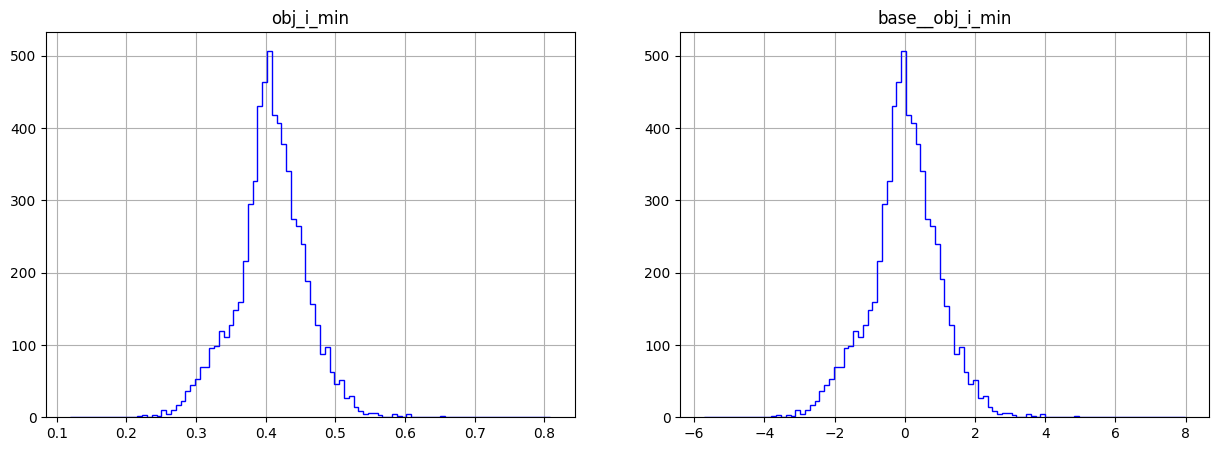

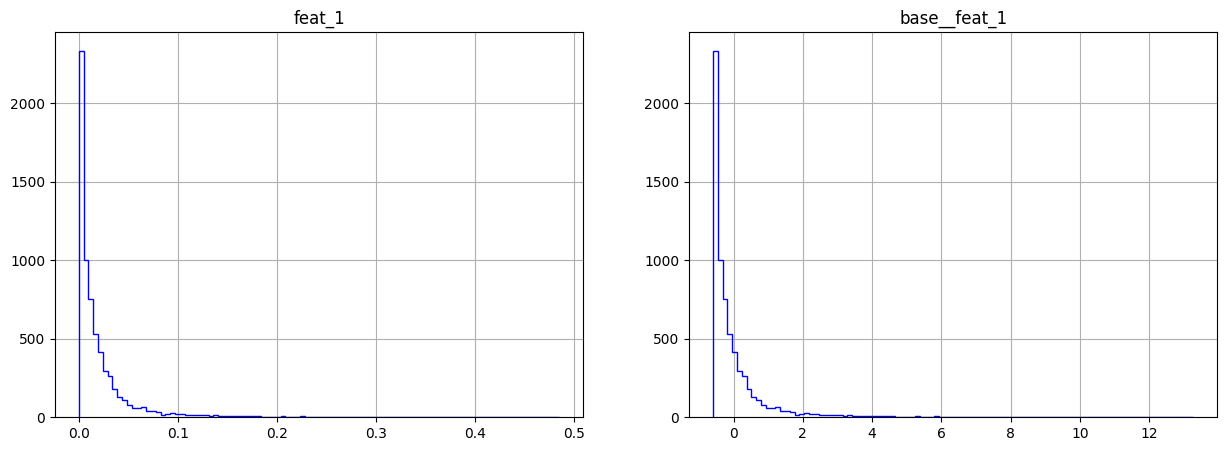

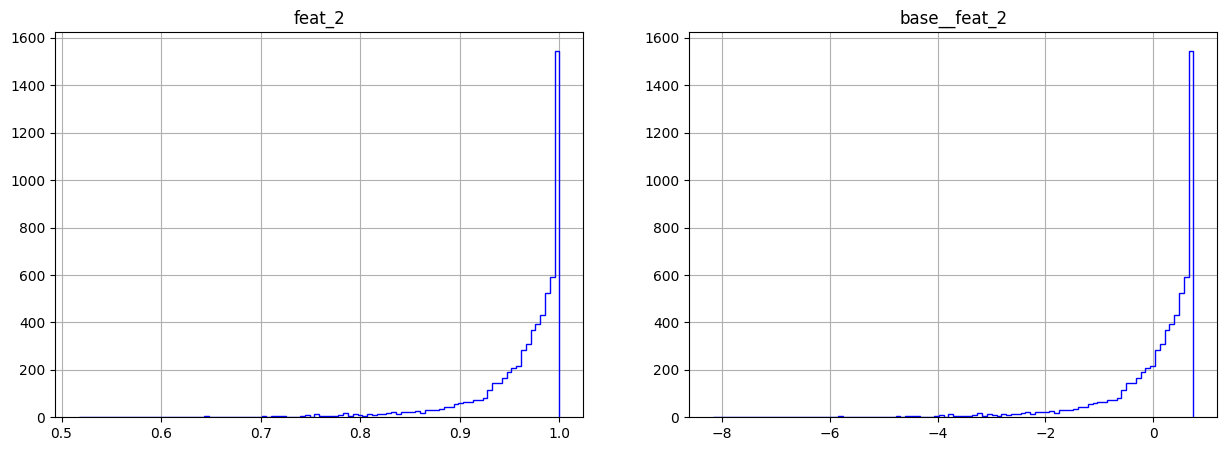

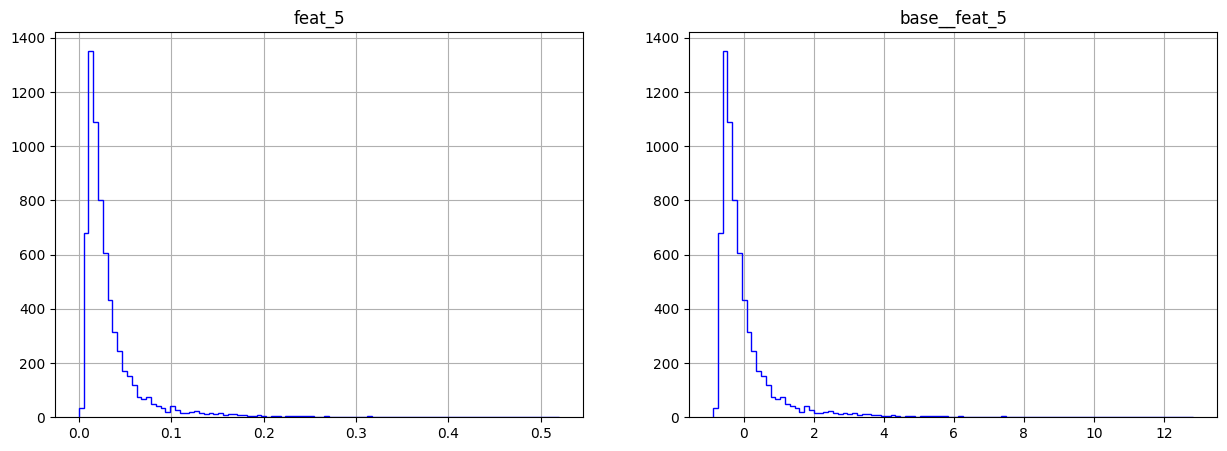

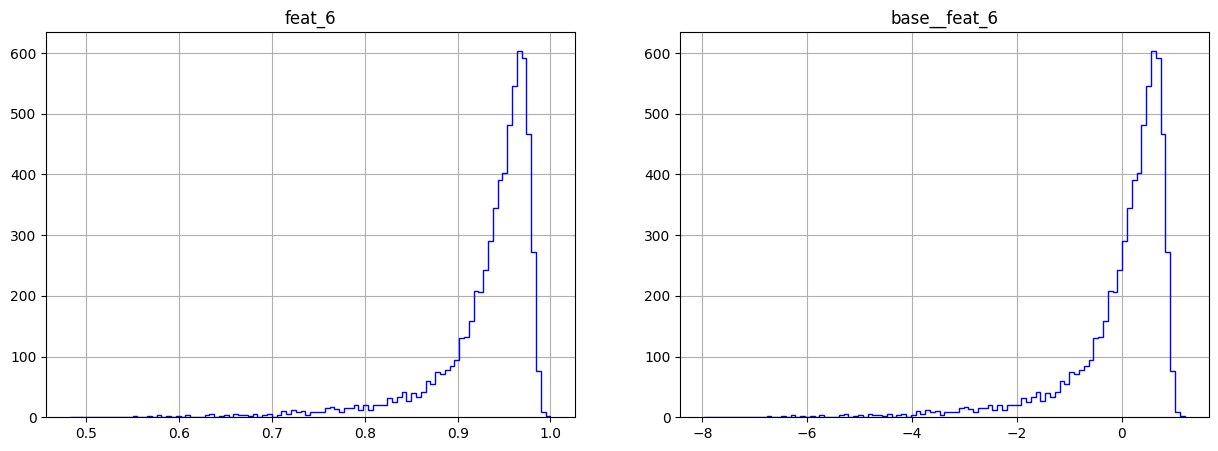

In [28]:
for col in df_train_scaled.loc[:, df_train_scaled.columns.isin(slc_fts)]:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].hist(df_train[col[col.find('__')+2:]], bins=100, density=False, histtype='step', log=False, color='blue')
    ax[0].set_title(col[col.find('__')+2:])
    ax[0].grid(True)
    ax[1].hist(df_train_scaled[col], bins=100, density=False, histtype='step', log=False, color='blue')
    ax[1].set_title(col)
    ax[1].grid(True)
    plt.show()

## KNeighborsClassifier

In [ ]:
model_knn = neighbors.KNeighborsClassifier(
    n_neighbors=15,
    weights='distance', ### ['uniform', 'distance']
    algorithm='kd_tree', ### ['auto', 'ball_tree', 'kd_tree', 'brute']
    p=1, ### power parameter for minkowski metric -> 1 é manhattan_distance e 2 é euclidean distance
    metric='minkowski' ### metric to use for distance computation -> ['euclidean', 'cosine', 'chebyshev', 'correlation', 'manhattan', 'minkowski']
)

##### Gridsearch

In [ ]:
param_grid = dict(
    n_neighbors=[2, 5, 7, 10, 15, 20, 25, 30],
    weights=['uniform', 'distance'],
    algorithm=['ball_tree', 'kd_tree', 'brute'],
    leaf_size=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    p=[1, 2],
    metric=['eucliedean', 'cosine', 'manhattan', 'minkowski']
    )

In [ ]:
grid_search = model_selection.GridSearchCV(model_knn, param_grid, cv=10, scoring='accuracy')
grid_search.fit(df_train.loc[:, slc_fts], df_train['roi_target'])

In [ ]:
grid_search.best_params_

In [ ]:
####### Primeiras 5 combinações com melhores resultados
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

##### RandomSearchCV

In [ ]:
param_dstb = dict(
    n_neighbors=stats.randint(low=1, high=100),
    weights=['uniform', 'distance'],
    algorithm=['ball_tree', 'kd_tree', 'brute'],
    leaf_size=stats.randint(low=1, high=100),
    p=[1, 2],
    metric=['eucliedean', 'manhattan', 'minkowski']
    )

In [ ]:
rnd_search = model_selection.RandomizedSearchCV(model_knn, param_distributions=param_dstb, n_iter=1000, cv=10, scoring='accuracy')
rnd_search.fit(df_train_scaled.loc[:, slc_fts], df_train_scaled['roi_target'])

In [ ]:
rnd_search.best_params_

In [ ]:
####### Primeiras 5 combinações com melhores resultados
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

##### Treinamento

In [ ]:
model_knn.fit(df_train_scaled.loc[:, slc_fts], df_train_scaled['roi_target'])

In [ ]:
cv_scores = model_selection.cross_val_score(model_knn, df_train_scaled.loc[:, slc_fts], df_train_scaled['roi_target'], cv=10, scoring='accuracy')

y_train_pred = model_selection.cross_val_predict(model_knn, df_train_scaled.loc[:, slc_fts], df_train_scaled['roi_target'], cv=10, method='predict')

##### Matriz de confusão

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(df_train_scaled['roi_target'], y_train_pred, normalize='true', values_format='.2%')
plt.show()

print('\nRecall score: ', '{:.2%}'.format(metrics.recall_score(df_train['roi_target'], y_train_pred)))
print('Precision score: ', '{:.2%}'.format(metrics.precision_score(df_train['roi_target'], y_train_pred)))
print('Accuracy: ', '{:.2%}'.format(metrics.accuracy_score(df_train['roi_target'], y_train_pred)))
print('F1-score: ', metrics.f1_score(df_train['roi_target'], y_train_pred))


##### Precisão vs Recall

In [ ]:
precisions, recalls, thresholds = metrics.precision_recall_curve(df_train_scaled['roi_target'], y_train_pred)

fig, ax = plt.subplots()
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel('Threshold')
plt.legend(loc='center right')
plt.grid(visible=True)
plt.show()

fig, ax = plt.subplots()
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(visible=True)
plt.show()


##### Curva ROC

In [ ]:
fpr, tpr, roc_thresh = metrics.roc_curve(df_train['roi_target'], y_train_pred)

print('ROC Area Under Curve: ', metrics.roc_auc_score(df_train['roi_target'], y_train_pred))

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="ROC curve")
plt.grid(visible=True)
plt.show()

## Neural Networks

#### Explorando hiperparâmetros

##### Montando a rede

In [ ]:
def build_model(hp):
######### Definindo os hiperparametros
    n_hidden = hp.Int('n_hidden', min_value=0, max_value=4, default=2)
    n_neurons = hp.Int('n_neurons', min_value=40, max_value=100)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = hp.Choice('optimizer', values=['sgd', 'adam'])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    ####### Montando o modelo
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=[33], batch_size=32))
    for i in range(n_hidden): ###### camadas intermediárias
        model.add(tf.keras.layers.Dense(n_neurons, activation='sigmoid'))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    ###### Compilando o modelo
    model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

    return model

##### RandomSearchTuner

In [ ]:
random_search_tuner = kt.RandomSearch(build_model,
                                    objective='val_accuracy',
                                    max_trials=15,
                                    overwrite=True,
                                    seed=654, #### random seed
                                    project_name='random_search_tuner'
)

In [ ]:
random_search_tuner.search(X_train, y_train, epochs=5000, validation_split=0.25, batch_size=32, shuffle=True,
                           callbacks=[cb_checkpoint, cb_early_stopping, cb_tensorboard], verbose=False)

In [ ]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=5)[2]
best_trial.summary()

##### HyperbandTuner

In [ ]:
hyperband_tuner =  kt.Hyperband(build_model, 
                                objective='val_accuracy',
                                max_epochs=100,
                                factor=3,
                                seed=654,
                                project_name='hyperband_tuner'
)

In [ ]:
hyperband_tuner.search(X_train, y_train, epochs=5000, validation_split=0.25, batch_size=32, shuffle=True,
                           callbacks=[cb_checkpoint, cb_early_stopping, cb_tensorboard], verbose=False)

In [ ]:
best_trial = hyperband_tuner.oracle.get_best_trials(num_trials=5)[2]
best_trial.summary()

#### Callbacks

In [29]:
##### Salvar o modelo conforme o checkpoint definido
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint_file.keras',
    monitor='val_accuracy', ### 'val_loss', 'val_recall', 'val_precision'
    verbose=False,
    save_best_only=True,
    mode='auto',
)

#### Interromper o treinamento conforme critérios estabelecidos
cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', ### 'val_accuracy', 'val_recall', 'val_precision'
    min_delta=0,
    patience=100,
    verbose=False,
    mode='auto',
    start_from_epoch=0,
    restore_best_weights=True
)

#### TensorBoard
cb_tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='logs'
)

#### Modelo final

In [44]:
X_train = df_train_scaled.loc[:, slc_fts]
y_train = df_train_scaled.loc[:, 'roi_target'].astype('bool')

dtype('bool')

In [45]:
model_nn = tf.keras.Sequential()
model_nn.add(tf.keras.layers.Input(shape=[X_train.shape[1]], batch_size=32))
model_nn.add(tf.keras.layers.Dense(65, activation='sigmoid'))
model_nn.add(tf.keras.layers.Dense(65, activation='sigmoid'))
model_nn.add(tf.keras.layers.Dense(65, activation='sigmoid'))
model_nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_nn.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00409),
                metrics=['accuracy'])

model_nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (32, 65)               │         1,885 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 65)               │         4,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 65)               │         4,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (32, 1)                │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,531 (41.14 KB)

 Trainable params: 10,531 (41.14 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model_nn.fit(X_train, y_train, epochs=5000, validation_split=0.25, batch_size=15, shuffle=True,
                           callbacks=[cb_checkpoint, cb_early_stopping, cb_tensorboard], verbose=False)

##### Avaliação

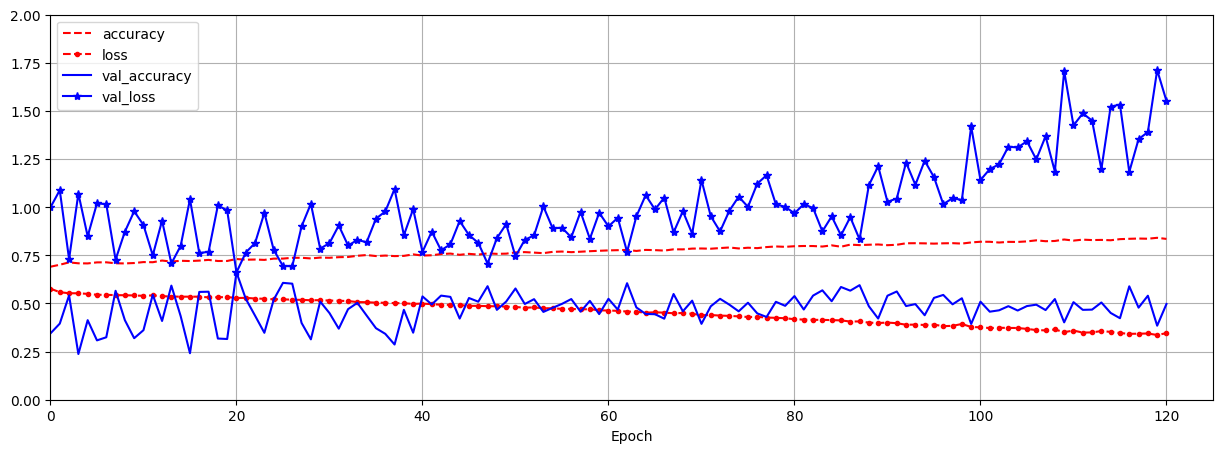

In [47]:
pd.DataFrame(history.history).plot(figsize=(15, 5), xlim=[0, 125], ylim=[0, 2], grid=True, xlabel="Epoch", 
                                  style=["r--", "r--.", "b-", "b-*"])
plt.show()

##### Teste e Avaliação

In [48]:
df_test = pd.concat([
    roi_test.loc[roi_test['roi_result']=='true_positive', :],
    roi_test.loc[roi_test['roi_result']=='false_positive', :]
])

df_test[['roi_result', 'roi_target']].value_counts()

roi_result      roi_target
false_positive  0             14341
true_positive   1              1649
Name: count, dtype: int64

In [49]:
##### Aplicar os operadores no dataframe
df_test_scaled = p_processing.fit_transform(df_test.loc[:, ~df_test.columns.isin(non_att)])
df_test_scaled = pd.concat([df_test_scaled, df_test['roi_target'], df_test['im_name']], axis=1)

In [51]:
test_grouped = df_test_scaled.groupby('im_name')

test_rstList = []
test_roiClass = []
for im_name, group in df_test_scaled.groupby('im_name'):
    X_imgTest = group.loc[:, slc_fts]
    y_imgTest = group['roi_target'].astype('bool')
    
    imgProba = model_nn.predict(X_imgTest, verbose=False)

    imgPred = imgProba >= 0.75

    tn, fp, fn, tp = metrics.confusion_matrix(y_imgTest, imgPred).ravel()

    group_dict = {
        'im_name': im_name,
        'true_positive': tp,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn,
        'sensibilidade': tp/(tp+fn),
        'especificidade': tn/(tn+fp),
        'precisao': metrics.precision_score(y_imgTest, imgPred),
        'acuracia': metrics.accuracy_score(y_imgTest, imgPred),
        'auc': metrics.roc_auc_score(y_imgTest, imgPred),
    }

    group_series = pd.DataFrame(imgPred, index=group.index)

    test_rstList.append(group_dict)
    test_roiClass.append(group_series)

In [52]:
test_sgmTable = roi_test.groupby(by='im_name')['roi_result'].value_counts()
test_sgmTable = test_sgmTable.unstack().fillna(value=0)

test_sgmTable['sensibilidade'] = test_sgmTable['true_positive']/(test_sgmTable['true_positive']+test_sgmTable['false_negative'])
test_sgmTable['especificidade'] = test_sgmTable['true_negative']/(test_sgmTable['true_negative']+test_sgmTable['false_positive'])
test_sgmTable['precisao'] = test_sgmTable['true_positive']/(test_sgmTable['true_positive']+test_sgmTable['false_positive'])
test_sgmTable['acuracia'] = (test_sgmTable['true_positive']+test_sgmTable['true_negative'])/(test_sgmTable['true_positive']+test_sgmTable['false_negative']+test_sgmTable['false_positive']+test_sgmTable['true_negative'])

In [53]:
test_rstTable = pd.DataFrame(test_rstList)
test_rstTable = test_rstTable.set_index(keys='im_name')

In [54]:
class_array = [
    np.array(['class', 'class', 'class', 'class', 'class', 'class', 'class', 'class', 'class']),
    np.array(['true_positive', 'true_negative', 'false_positive', 'false_negative', 'sensibilidade', 'especificidade', 'precisao', 'acuracia', 'auc'])
]

sgm_array = [
    np.array(['sgm', 'sgm', 'sgm', 'sgm', 'sgm', 'sgm', 'sgm', 'sgm']),
    np.array(['false_negative', 'false_positive', 'true_negative', 'true_positive', 'sensibilidade', 'especificidade', 'precisao', 'acuracia'])
]

result_table_1 = pd.concat([test_sgmTable.T.set_index(pd.MultiIndex.from_arrays(sgm_array)).T, test_rstTable.T.set_index(pd.MultiIndex.from_arrays(class_array)).T], axis=1)

highlight_sensi = result_table_1.loc[:, ('class', 'sensibilidade')] > result_table_1.loc[:, ('sgm', 'sensibilidade')]
highlight_sensi = highlight_sensi[highlight_sensi].index
highlight_preci = result_table_1.loc[:, ('class', 'precisao')] > result_table_1.loc[:, ('sgm', 'precisao')]
highlight_preci = highlight_preci[highlight_preci].index
highlight_acura = result_table_1.loc[:, ('class', 'acuracia')] > result_table_1.loc[:, ('sgm', 'acuracia')]
highlight_acura = highlight_acura[highlight_acura].index
highlight_espec = result_table_1.loc[:, ('class', 'especificidade')] > result_table_1.loc[:, ('sgm', 'especificidade')]
highlight_espec = highlight_espec[highlight_espec].index

result_table_1.style \
    .format(precision=0) \
    .format(precision=2, subset=[('class', 'auc')]) \
    .format(formatter='{:.2%}', thousands='.', decimal=',', subset=[('sgm', 'sensibilidade'), ('sgm', 'especificidade'), ('sgm', 'acuracia'), ('sgm', 'precisao'), ('class', 'sensibilidade'), ('class', 'especificidade'), ('class', 'acuracia'), ('class', 'precisao')]) \
    .highlight_between(subset=(highlight_sensi, ('class', 'sensibilidade')), color='green', left=0, right=100) \
    .highlight_between(subset=(highlight_acura, ('class', 'acuracia')), color='green', left=0, right=100) \
    .highlight_between(subset=(highlight_preci, ('class', 'precisao')), color='green', left=0, right=100) \
    .highlight_between(subset=(highlight_espec, ('class', 'especificidade')), color='green', left=0, right=100)

In [55]:
result_table_2 = pd.DataFrame([result_table_1.mean(), result_table_1.std()], index=['mean', 'std']).T
result_table_2 = result_table_2.unstack(0)

result_table_2.columns

result_table_2.style \
    .format(precision=2) \
    .format(formatter='{:.2%}', thousands='.', decimal=',', subset=pd.IndexSlice[['sensibilidade', 'especificidade', 'precisao', 'acuracia'], :]) \
    .relabel_index(labels=['Mean', 'Mean', 'STD', 'STD'], axis=1, level=0) \
    .relabel_index(labels=['Class.', 'Segm.', 'Class.', 'Segm.'], axis=1, level=1) \
    .relabel_index(labels=['Acurácia', 'AUC', 'Especif.', 'FN', 'FP', 'Precisão', 'Sensib.', 'TN', 'TP'], axis=0)

In [64]:
test_df = pd.DataFrame({'segm_result': roi_test['roi_result'],
                        'roi_target': roi_test['roi_target'].astype('bool')
                        })

test_classRST = pd.concat(test_roiClass)
test_df = pd.concat([test_df, test_classRST], axis = 1)
test_df.columns = ['segm_result', 'roi_target', 'class_result']
test_df['segm_result'] = test_df['segm_result'].replace({'false_positive':True, 'true_positive':True, 'true_negative':False, 'false_negative':False}).astype('bool')
test_df['roi_target'] = test_df['roi_target'].replace({0:False, 1:True})
test_df['class_result'] = test_df['class_result'].fillna(False).astype('bool')

print(metrics.confusion_matrix(test_df['roi_target'], test_df['class_result']))
print(metrics.accuracy_score(test_df['roi_target'], test_df['class_result']))
print(metrics.precision_score(test_df['roi_target'], test_df['class_result']))
print(metrics.roc_auc_score(test_df['roi_target'], test_df['class_result']))

[[43269  2661]
 [  957   911]]
0.9243064563370852
0.25503919372900336
0.7148756883088547
